In [1]:
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get spotify credentials
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id= '6426e18767ac42d78a9c08f41cacba65',
                                                     client_secret= '4a2cdab50e1c4ecd9fc62cae20664e29')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
# get all file names
# chordPath  = '/Users/aaronlevi/Documents/Insight2020/chordRec/chords/'
chordPath  = '/Users/aaronlevi/Documents/Insight2020/chordRec/ug_chords/'

chordFiles = [f for f in listdir(chordPath) if isfile(join(chordPath, f))]

chordFiles.remove('.DS_Store')

In [4]:
# put together a list of various standard major & minor chords
sl1 = ['A', 'Bb', 'B', 'C', 'C#', 'Db', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'Ab' ]
sl2 = [s + 'maj' for s in sl1]
sl3 = [s + 'm' for s in sl1]
sl4 = [s + 'min' for s in sl1]

standardList = sl1+sl2+sl3+sl4

In [5]:
# load each song csv, get some metrics
nUniqueChords   = []
nHardChords     = []
difficultyLabel = []

spotFeatures = {}

spotFeatures['key'] = []
spotFeatures['tempo'] = []
spotFeatures['duration_ms'] = []
spotFeatures['time_signature'] = []
spotFeatures['energy'] = []

for iSong in range(0, len(chordFiles)):
#     dfSong = pd.read_csv(chordPath+chordFiles[iSong])
    dfSong = pd.read_csv(chordPath+chordFiles[iSong], sep='delimiter', header=None)

    songName   = dfSong[0][0].split(',')[1].replace('-', ' ').title()
    artistName = dfSong[0][1].split(',')[1].replace('-', ' ').title()
    
    difficultyLabel.append(dfSong[0][3].split(',')[1])
    
#     if dfSong.size==3:
    uniqChords = dfSong[0][2].split(',')[1:]
    nUniqueChords.append(len(uniqChords))

    tmpHard = []
    for kCh in range(0, nUniqueChords[iSong]):
        tmpHard.append(uniqChords[kCh] in standardList)

    nHardChords.append(sum(tmpHard));

    # search song in spotify api
    result = sp.search(songName) #search query
    nItems = len(result['tracks']['items'])

    # match artist info, and get URI
    for iArtist in range(0, nItems):    
        if result['tracks']['items'][iArtist]['artists'][0]['name'] == artistName:
           songURI = result['tracks']['items'][iArtist]['uri']
    
#     %debug magic    
    # pull audio features for a songURI
    features = sp.audio_features(songURI)

    spotFeatures['key'].append(features[0]['key'])
    spotFeatures['tempo'].append(features[0]['tempo'])
    spotFeatures['duration_ms'].append(features[0]['duration_ms'])
    spotFeatures['time_signature'].append(features[0]['time_signature'])
    spotFeatures['energy'].append(features[0]['energy'])


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


//anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


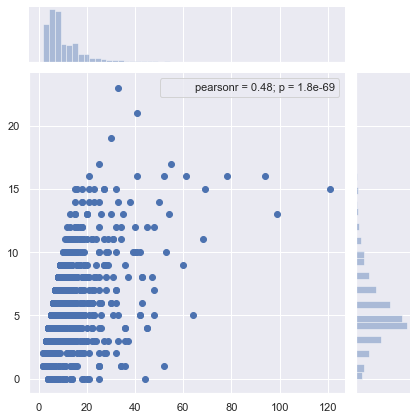

In [6]:
import scipy.stats as stats

sns.set(style="darkgrid", color_codes=True)
h = sns.jointplot(nUniqueChords, nHardChords)
h.annotate(stats.pearsonr)
plt.show()


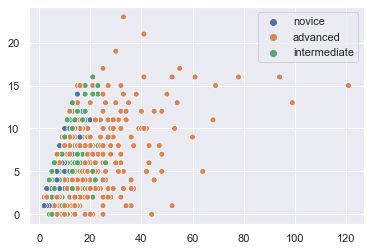

In [7]:
sns.scatterplot(nUniqueChords, nHardChords, hue=difficultyLabel)

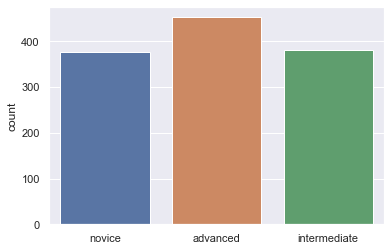

In [8]:
sns.countplot(difficultyLabel)

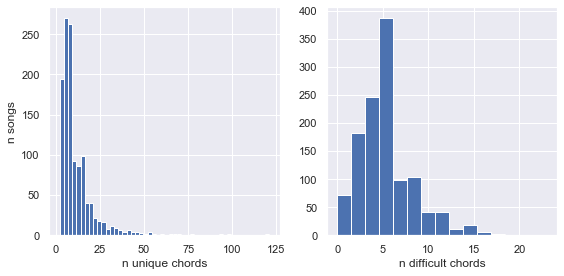

In [9]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].hist(nUniqueChords, bins=50)
ax[0].set_xlabel('n unique chords')
ax[0].set_ylabel('n songs')

ax[1].hist(nHardChords, bins=15)
ax[1].set_xlabel('n difficult chords')

plt.tight_layout()

In [10]:
[np.median(nUniqueChords), np.median(nHardChords)]

[8.0, 5.0]

In [11]:
spotFeatures = pd.DataFrame.from_dict(spotFeatures)
spotFeatures.head()

,key,tempo,duration_ms,time_signature,energy
0,3,174.117,189507,4,0.0581
1,3,174.117,189507,4,0.0581
2,0,120.042,215280,4,0.7620
3,2,124.958,246493,3,0.2170
4,7,147.909,230999,4,0.6610


In [12]:
allFeatures = spotFeatures

allFeatures['n_unique_chords']    = nUniqueChords
allFeatures['n_difficult_chords'] = nHardChords

dummyLabel=pd.get_dummies(difficultyLabel)
featuresWithLabels = pd.concat([allFeatures, dummyLabel], axis=1, sort=False)

# featuresWithLabels = allFeatures
# featuresWithLabels['difficulty'] = pd.factorize(difficultyLabel)[0]
# featuresWithLabels.head()

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


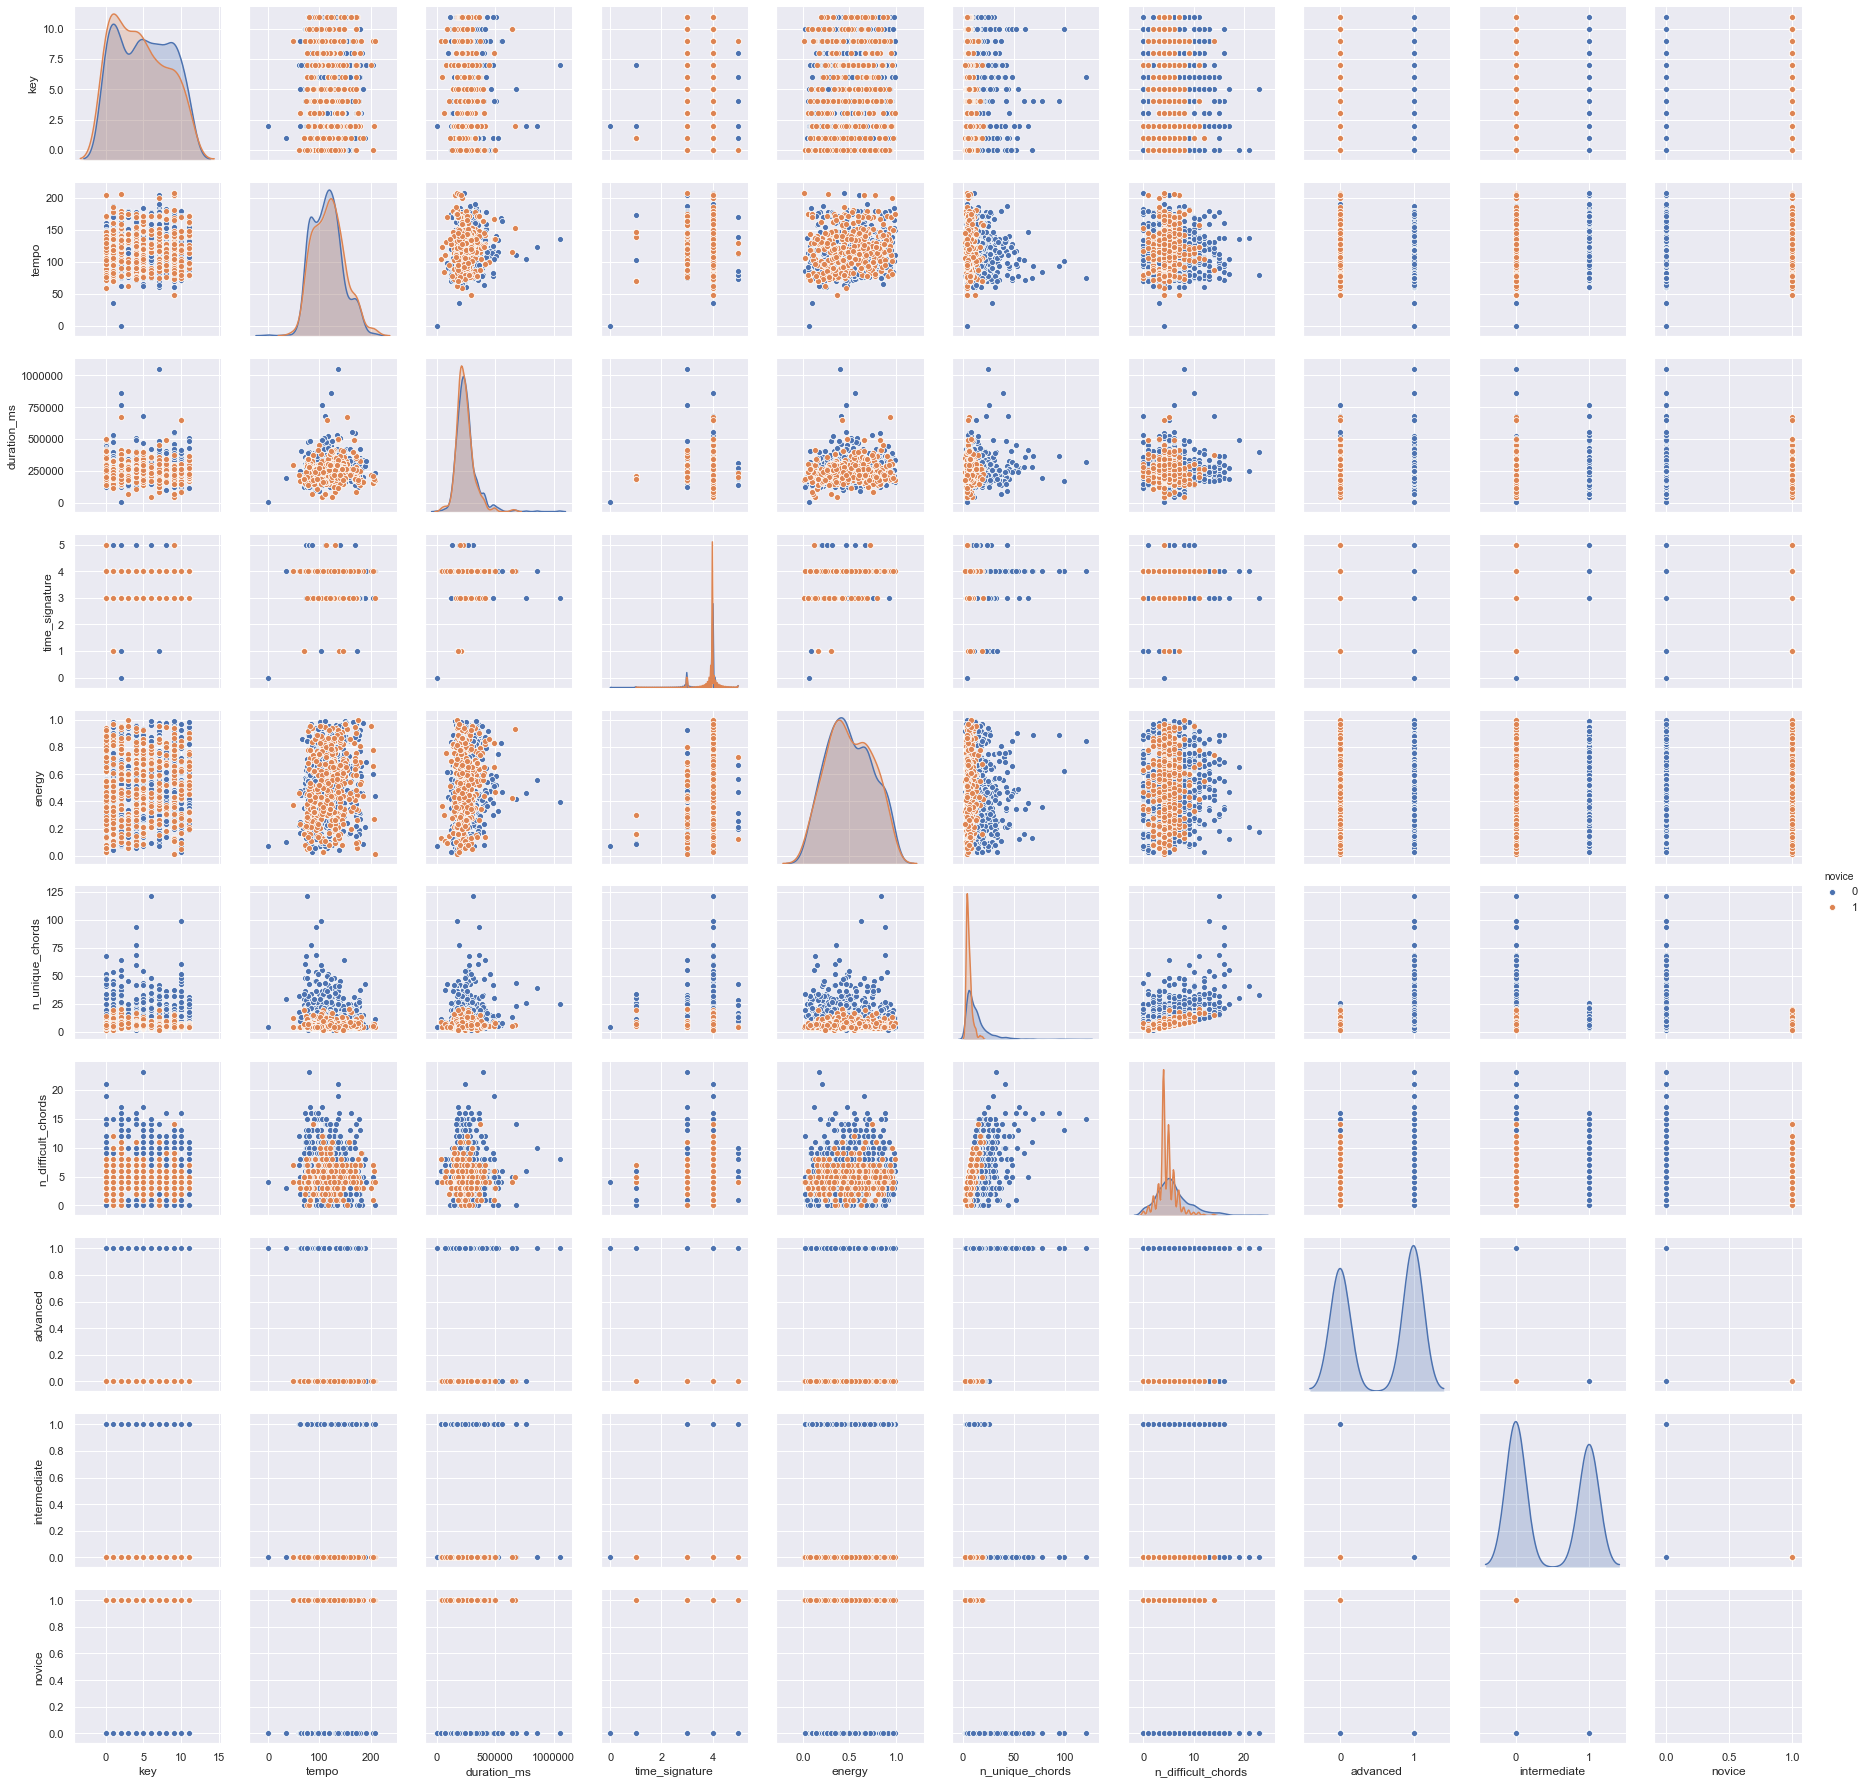

In [13]:
# sns.pairplot(allFeatures)
sns.pairplot(featuresWithLabels, hue='novice')

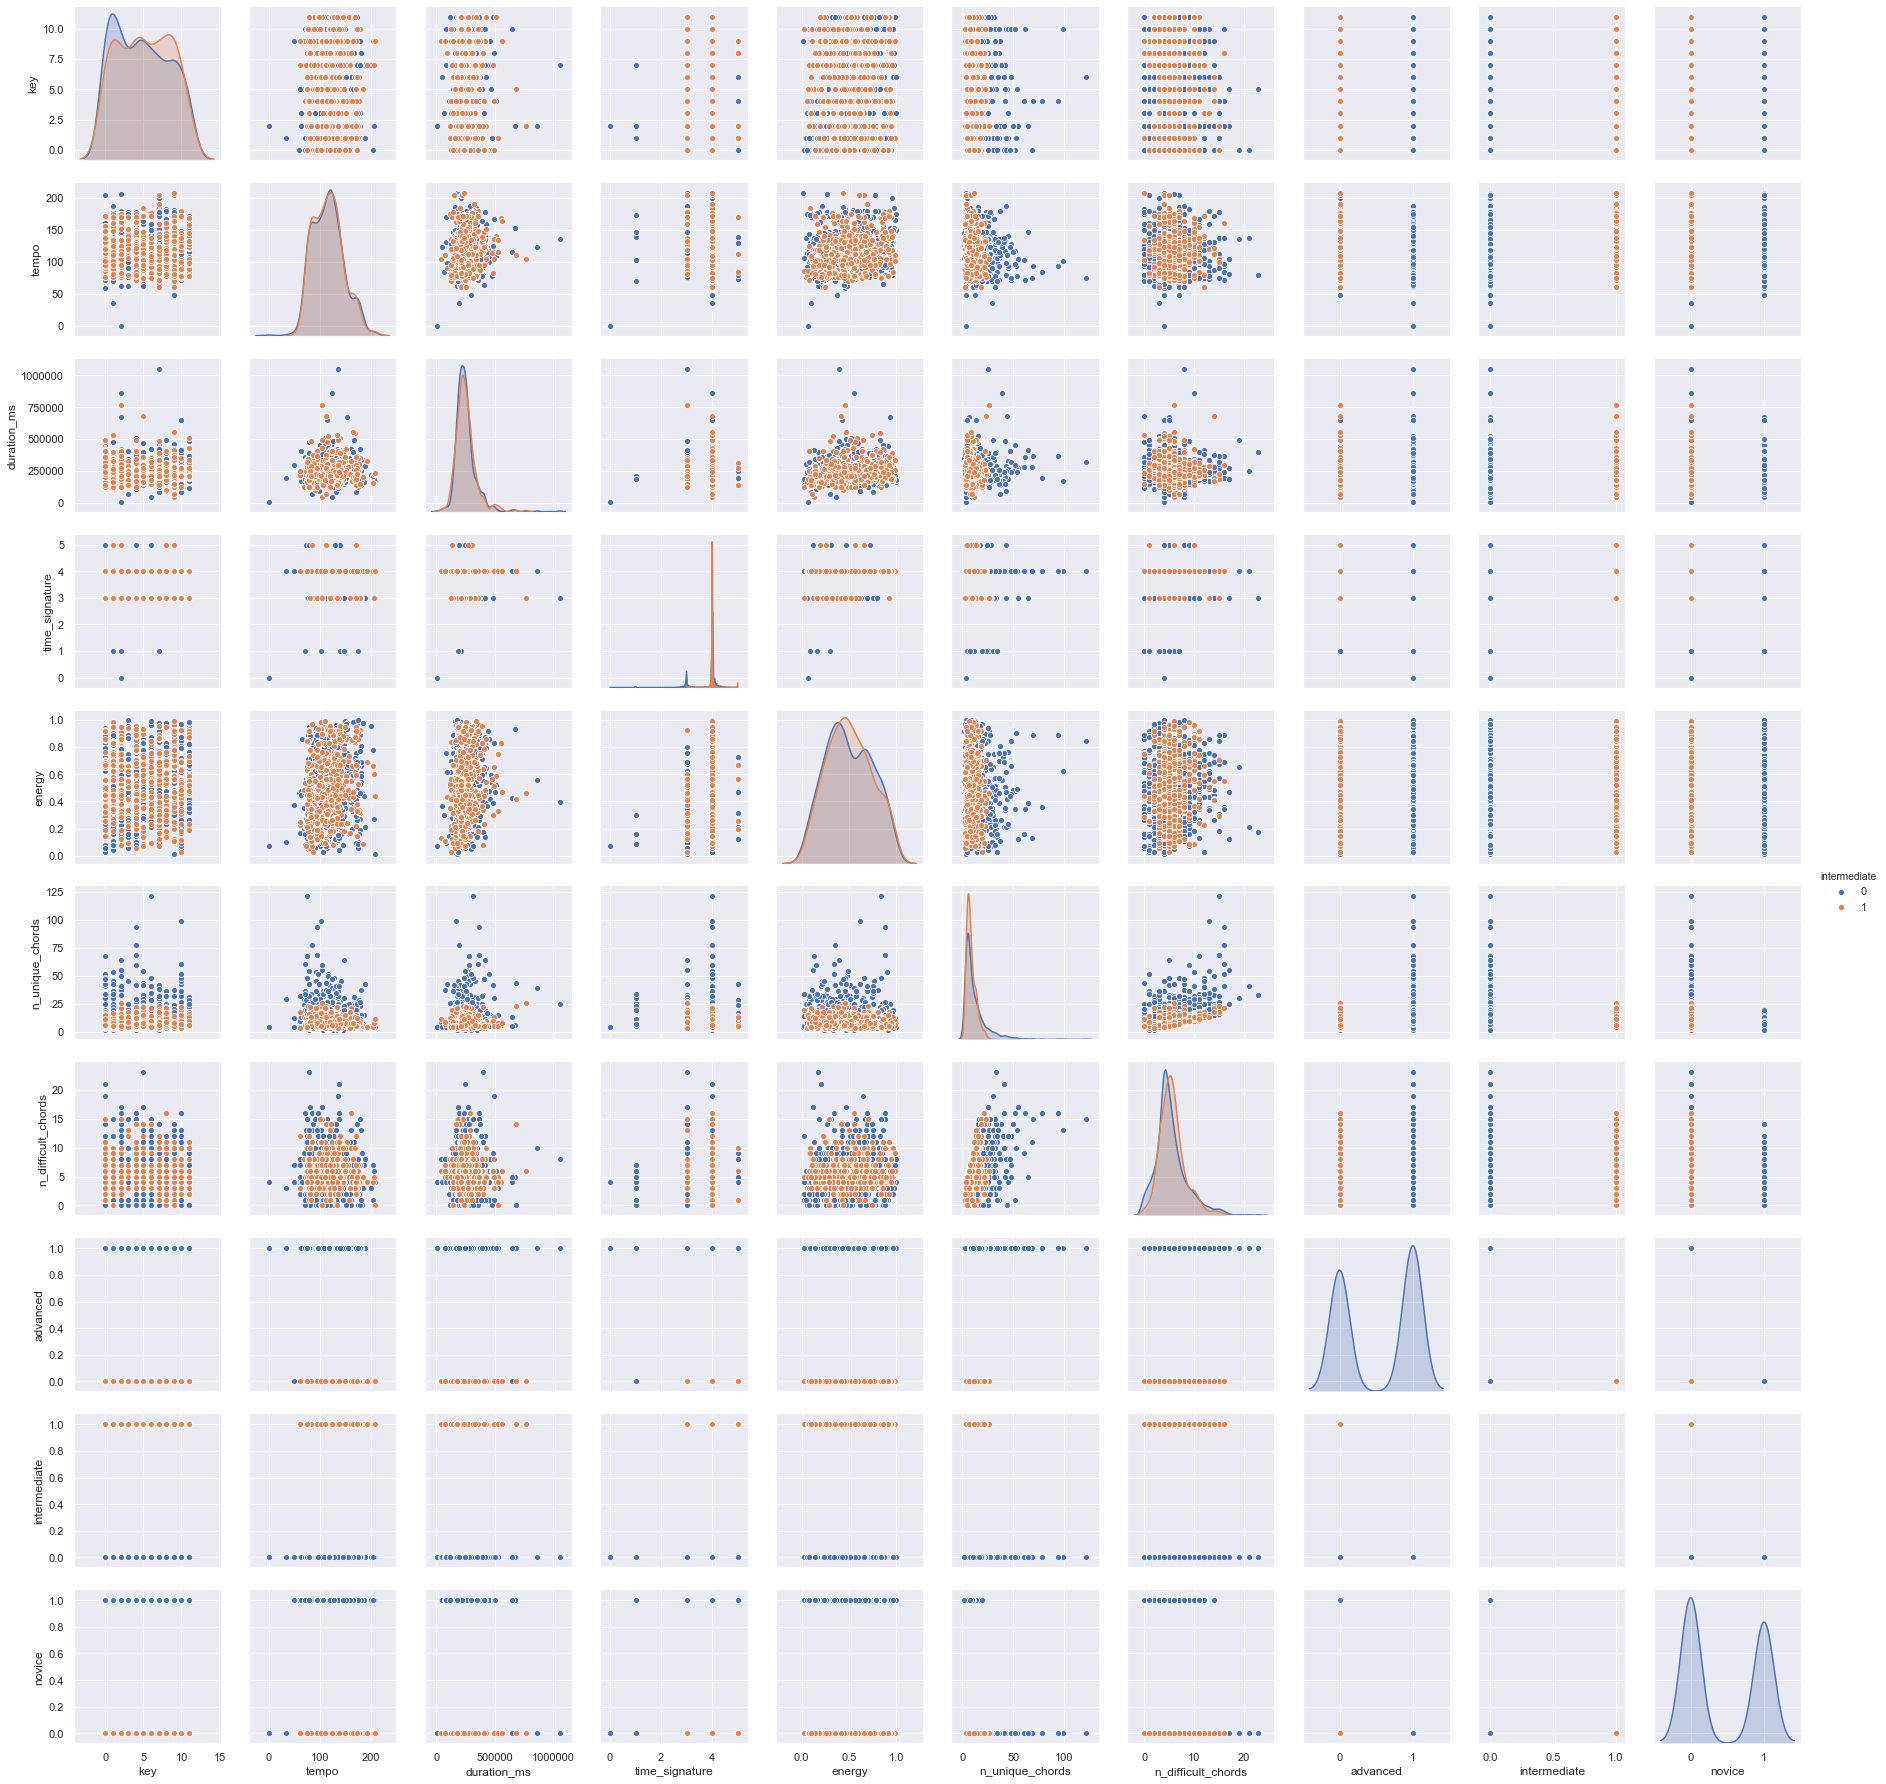

In [14]:
sns.pairplot(featuresWithLabels, hue='intermediate')

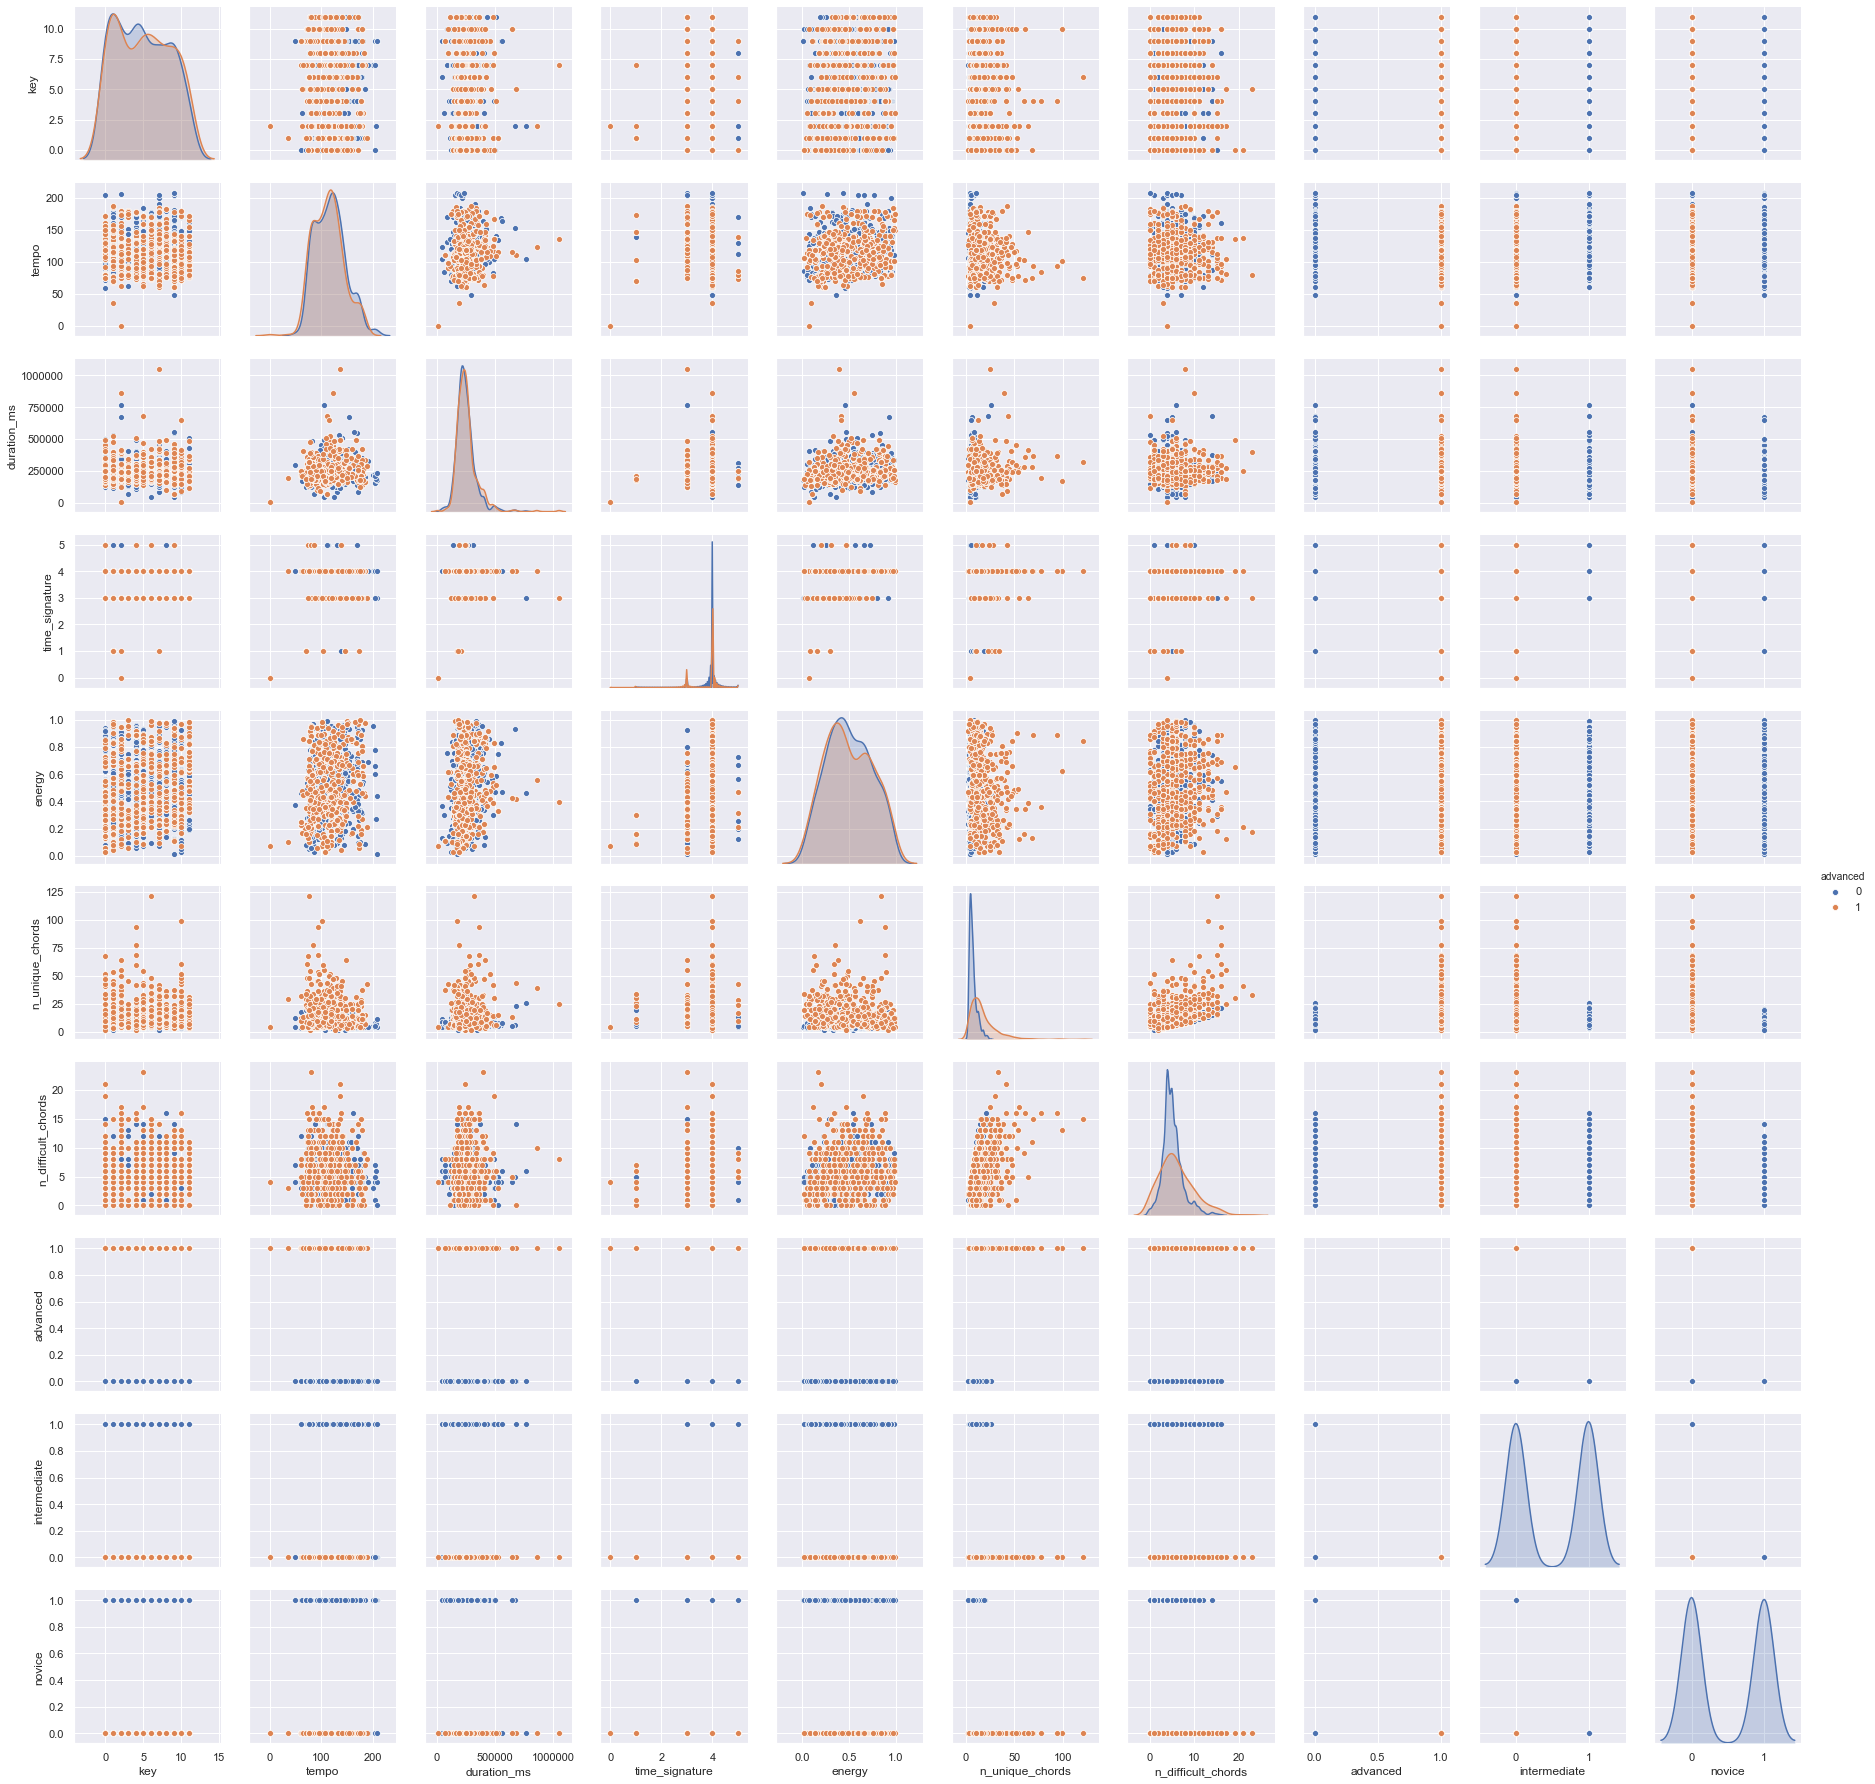

In [15]:
sns.pairplot(featuresWithLabels, hue='advanced')

In [16]:
# KMEANS ON UNLABELED DATA
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
# kmeans.fit(allFeatures)

dfFeatures = allFeatures.drop(['key', 'duration_ms', 'energy'], axis=1)
kmeans.fit(dfFeatures)

# kmeans.cluster_centers_
# kmeans.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

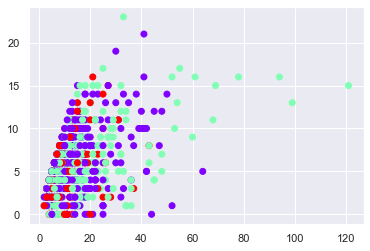

In [17]:
plt.scatter(allFeatures['n_unique_chords'],allFeatures['n_difficult_chords'],c=kmeans.labels_,cmap='rainbow')
# plt.scatter(allFeatures['n_unique_chords'],allFeatures['time_signature'],c=kmeans.labels_,cmap='rainbow')


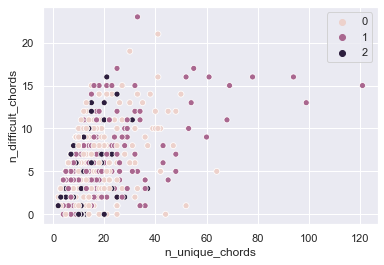

In [18]:
sns.scatterplot(allFeatures['n_unique_chords'], allFeatures['n_difficult_chords'], hue=kmeans.labels_)

In [19]:
print(kmeans.labels_)

[2 2 0 ... 0 0 0]


In [20]:
correct = pd.factorize(difficultyLabel)[0]==kmeans.labels_
correct.mean()

0.33910891089108913

In [21]:
# RANDOM FOREST ON LABELED DATA
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(allFeatures, pd.factorize(difficultyLabel)[0], test_size=0.33, random_state=42)

from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
predictions = dtree.predict(X_test)
print(predictions)

[0 0 2 1 1 0 1 2 2 2 2 0 2 1 1 2 0 1 0 0 2 0 1 2 0 1 1 2 0 2 2 0 1 2 1 0 0
 0 2 1 0 1 0 0 0 1 2 1 1 1 0 2 1 1 2 1 2 0 1 2 1 1 1 0 1 1 2 2 1 2 0 2 2 1
 0 2 0 2 2 0 0 0 0 2 2 1 2 1 2 2 0 2 2 2 2 0 0 1 0 1 0 0 0 1 2 1 1 2 2 2 1
 0 0 0 2 0 1 0 0 1 0 0 2 1 1 1 2 2 1 1 1 0 1 2 1 2 1 1 1 0 2 2 1 2 1 1 0 0
 2 2 0 1 2 1 0 1 0 1 1 2 1 2 1 0 2 1 2 1 2 0 2 2 2 2 2 1 0 0 1 1 2 2 1 1 2
 0 1 2 1 0 1 0 1 0 2 1 1 0 2 1 1 2 1 1 1 1 0 2 2 0 0 2 0 1 2 2 0 0 0 1 2 2
 0 0 0 1 1 2 0 2 2 2 1 0 1 1 2 2 0 1 1 2 2 2 1 1 2 2 0 1 2 2 2 1 2 1 2 0 0
 2 1 1 2 1 2 1 0 1 1 1 1 2 1 0 0 1 2 1 0 1 1 1 0 1 2 2 1 1 1 2 2 1 2 2 2 0
 0 0 0 2 1 1 2 0 2 0 2 2 0 0 0 1 0 2 0 1 1 2 2 1 2 2 0 1 2 1 1 1 1 1 1 1 2
 0 0 0 1 0 1 1 0 0 1 1 2 0 2 1 2 1 2 2 0 1 0 0 0 1 2 0 1 0 1 2 2 0 2 2 2 2
 0 1 2 0 0 2 0 2 1 1 1 0 2 0 1 2 2 0 1 0 0 0 0 2 1 1 2 2 2 2]


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[58 20 52]
 [24 86 31]
 [35 38 56]]


              precision    recall  f1-score   support

           0       0.50      0.45      0.47       130
           1       0.60      0.61      0.60       141
           2       0.40      0.43      0.42       129

    accuracy                           0.50       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.50      0.50      0.50       400



In [105]:
allFeatures.drop('difficulty', axis=1, inplace=True)
allFeatures.head()

In [24]:
# try again with fewer features...? dropped: key, duration, energy 
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, pd.factorize(difficultyLabel)[0], test_size=0.33, random_state=42)

from sklearn.tree import DecisionTreeClassifier
dtree2 = DecisionTreeClassifier()
dtree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [29]:
predictions2 = dtree2.predict(X_test)

predictions2

array([2, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 0,
       1, 2, 0, 2, 1, 0, 2, 2, 0, 0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0,
       0, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1,
       0, 1, 2, 0, 1, 0, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 0, 2, 2,
       2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 1, 1, 2, 0, 0,
       1, 2, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 2,
       1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1,
       0, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 0,
       1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 1, 2,
       1, 1, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 0, 0, 0,
       1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2,

In [30]:
print(confusion_matrix(y_test, predictions2))
print('\n')
print(classification_report(y_test, predictions2))

[[58 28 44]
 [30 75 36]
 [42 36 51]]


              precision    recall  f1-score   support

           0       0.45      0.45      0.45       130
           1       0.54      0.53      0.54       141
           2       0.39      0.40      0.39       129

    accuracy                           0.46       400
   macro avg       0.46      0.46      0.46       400
weighted avg       0.46      0.46      0.46       400



In [32]:
samePred = predictions == predictions2
samePred.mean()

0.5

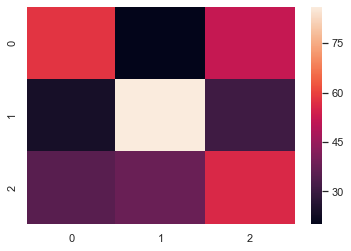

In [35]:
sns.heatmap(confusion_matrix(y_test, predictions))